In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
df = pd.read_csv(url)


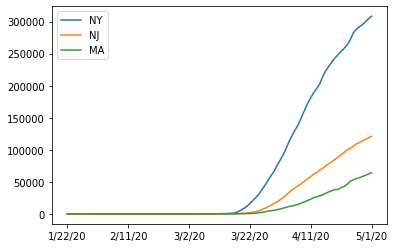

In [3]:
#group by states
df_by_state = df.groupby("Province_State").sum()
df_by_state_clean = df_by_state.sort_values(by = '4/27/20', ).drop(['UID', 'code3', 'FIPS', 'Lat', 'Long_'], axis = 1) 
df = pd.DataFrame({
   'NY': df_by_state_clean.iloc[-1],
   'NJ': df_by_state_clean.iloc[-2],
   'MA': df_by_state_clean.iloc[-3],
   })
lines = df.plot.line()

In [4]:
date = df_by_state_clean.columns
df_by_state_clean = df_by_state_clean.transpose()
#df_by_state_clean['date'] = date 
df_by_state_clean

Province_State,American Samoa,Northern Mariana Islands,Diamond Princess,Virgin Islands,Grand Princess,Guam,Alaska,Montana,Wyoming,Hawaii,...,Connecticut,Louisiana,Florida,Michigan,Pennsylvania,California,Illinois,Massachusetts,New Jersey,New York
1/22/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/23/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/24/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1/25/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1/26/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4/27/20,0,14,49,57,103,141,345,449,520,607,...,25997,27068,32138,38210,43558,44966,45883,56462,111188,291996
4/28/20,0,14,49,57,103,141,351,451,536,609,...,26312,27286,32848,39262,45137,46164,48102,58302,113856,295106
4/29/20,0,14,49,57,103,141,355,451,545,613,...,26767,27660,33193,40399,46327,48747,50358,60265,116365,299691
4/30/20,0,14,49,66,103,145,355,453,559,618,...,27700,28001,33690,41379,47971,50130,52918,62205,118652,304372


In [5]:
#judge critieria 
def root_mean_squared_log_error(y_true, y_pred, smooth=1):
  return np.sqrt((1 / len(y_true)) * np.sum((np.log(y_true + smooth) - np.log(y_pred + smooth)) ** 2))

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Activation, Dropout
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from pandas import DataFrame

In [7]:
def by_state(state,data):
  return data[state]

def clean_zeros(data):
  return data[data != 0]

In [8]:
data_ny = by_state('New York', df_by_state_clean)
data_ny = clean_zeros(data_ny)# remove zero

In [9]:
#train test split
train_ny,test_ny= train_test_split(data_ny,test_size=0.2, random_state=42,shuffle=False)
test_ny.values

array([243382, 248416, 253519, 258222, 263460, 271590, 282143, 288045,
       291996, 295106, 299691, 304372, 308314], dtype=int64)

In [10]:
#calculate difference instead of original data
def difference(dataset, interval = 1):
  diff = []
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return np.array(diff)

def inverse_diff(orginal_data, prediction):
  length = len(prediction)
  return prediction + orginal_data[-length:]

In [11]:
#build input data
def supervised_train_set(data,back_step):
     df = DataFrame()
     x = data
     length = x.shape[0]
     df['t'] = [x[i] for i in range(x.shape[0])]
     x=df['t'].values
     cols=list()
     df['t+1'] = df['t'].shift(-back_step)
     cols.append(df['t+1'])
     #df['t+2'] = df['t'].shift(-(back_step+1))
     #cols.append(df['t+2'])
     #df['t+3'] = df['t'].shift(-(back_step+2))
     #cols.append(df['t+3'])
     agg = pd.concat(cols,axis=1)
     agg.fillna(0, inplace = True)
     y=agg.values
     x = x.reshape(x.shape[0],1)
     len_X = length-back_step-2
     X=np.zeros((len_X,1,1))
     Y=np.zeros((len_X,1))
     for i in range(len_X):
        X[i] = x[i:(i+back_step)]
        Y[i] = y[i]

     return X,Y


In [12]:
back_step = 1
train = difference(train_ny)
test = difference(test_ny)
print(train.shape)
trainX, trainY = supervised_train_set(train, back_step)
testX, testY = supervised_train_set(test, back_step)

(47,)


In [13]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(44, 1, 1)
(44, 1)
(9, 1, 1)
(9, 1)


In [14]:
#scale the data
from sklearn.preprocessing import MinMaxScaler
def scale(train, test):
  scaler = MinMaxScaler(feature_range=(-1,1))
  shape_train = train.shape
  shape_test = test.shape
  train = train.reshape(train.shape[0],train.shape[1])
  scaler.fit(train)
  train_scaled = scaler.transform(train)
  train_scaled = train_scaled.reshape(shape_train)
  test = test.reshape(test.shape[0],test.shape[1])
  test_scaled = scaler.transform(test)
  test_scaled = test_scaled.reshape(shape_test)
  return scaler, train_scaled, test_scaled


def invert_scale(scaler, X, value):
  new_row = [x for x in X] + [value]
  array = np.array(new_row)
  array = array.reshape(1, len(array))
  inverted = scaler.inverse_transform(array)
  return inverted[0,-1]

In [15]:
scalerX, trainX_scaled, testX_scaled = scale(trainX, testX)
scalerY, trainY_scaled, testY_scaled = scale(trainY, testY)
print(trainX_scaled.shape)

(44, 1, 1)


In [16]:
from keras import optimizers
from sklearn.metrics import mean_squared_error
from keras.models import load_model
from keras.optimizers import adam
from tensorflow.keras.optimizers import Adam

Using TensorFlow backend.


In [17]:
def fit_lstm_model(trainX,trainY,testX,testY,batch_size, epochs, verbose, input_shape=(back_step,1)):
    model = Sequential()
    model.add(LSTM(64,activation='relu',return_sequences=True, input_shape=input_shape))
    model.add(LSTM(64,activation='relu'))
    model.add(Dense(1))
    myOptimizer = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=0.01, decay=0.0)
    model.compile(loss='mean_squared_error', optimizer=myOptimizer)
    his = model.fit(trainX, trainY, epochs=epochs,validation_data=(testX,testY), batch_size=batch_size, verbose=verbose)
    return his

In [18]:
lstm_model = fit_lstm_model(trainX_scaled,trainY_scaled,testX_scaled,testY_scaled,batch_size=1, epochs=1000, verbose = 1, input_shape=(back_step,1))

Train on 44 samples, validate on 9 samples
Epoch 1/1000
44/44 [==============================] - 2s 49ms/sample - loss: 0.5078 - val_loss: 0.1461
Epoch 2/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.4885 - val_loss: 0.1474
Epoch 3/1000
44/44 [==============================] - 0s 4ms/sample - loss: 0.4469 - val_loss: 0.1429
Epoch 4/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.2491 - val_loss: 0.0965
Epoch 5/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0441 - val_loss: 0.1320
Epoch 6/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0336 - val_loss: 0.1132
Epoch 7/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0332 - val_loss: 0.1266
Epoch 8/1000
44/44 [==============================] - 0s 4ms/sample - loss: 0.0342 - val_loss: 0.1136
Epoch 9/1000
44/44 [==============================] - 0s 4ms/sample - loss: 0.0313 - val_loss: 0.1125
Epoch 10/1000
44/44 [=================

44/44 [==============================] - 0s 3ms/sample - loss: 0.0369 - val_loss: 0.1231
Epoch 81/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0331 - val_loss: 0.1337
Epoch 82/1000
44/44 [==============================] - 0s 2ms/sample - loss: 0.0300 - val_loss: 0.1122
Epoch 83/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0350 - val_loss: 0.1034
Epoch 84/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0321 - val_loss: 0.1444
Epoch 85/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0323 - val_loss: 0.1170
Epoch 86/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0328 - val_loss: 0.1372
Epoch 87/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0324 - val_loss: 0.1106
Epoch 88/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0317 - val_loss: 0.1117
Epoch 89/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0306 - v

44/44 [==============================] - 0s 3ms/sample - loss: 0.0322 - val_loss: 0.1076
Epoch 160/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0378 - val_loss: 0.1101
Epoch 161/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0335 - val_loss: 0.1257
Epoch 162/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0313 - val_loss: 0.1132
Epoch 163/1000
44/44 [==============================] - 0s 4ms/sample - loss: 0.0305 - val_loss: 0.1128
Epoch 164/1000
44/44 [==============================] - 0s 4ms/sample - loss: 0.0322 - val_loss: 0.1147
Epoch 165/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0359 - val_loss: 0.1275
Epoch 166/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0369 - val_loss: 0.1334
Epoch 167/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0347 - val_loss: 0.1224
Epoch 168/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0

Epoch 238/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0321 - val_loss: 0.1255
Epoch 239/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0333 - val_loss: 0.1299
Epoch 240/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0300 - val_loss: 0.1173
Epoch 241/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0300 - val_loss: 0.1037
Epoch 242/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0333 - val_loss: 0.1283
Epoch 243/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0366 - val_loss: 0.1225
Epoch 244/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0313 - val_loss: 0.1119
Epoch 245/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0312 - val_loss: 0.1231
Epoch 246/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0316 - val_loss: 0.1142
Epoch 247/1000
44/44 [==============================] - 0s 3ms/s

Epoch 317/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0322 - val_loss: 0.1265
Epoch 318/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0313 - val_loss: 0.1063
Epoch 319/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0409 - val_loss: 0.1110
Epoch 320/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0310 - val_loss: 0.1210
Epoch 321/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0320 - val_loss: 0.1163
Epoch 322/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0311 - val_loss: 0.1210
Epoch 323/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0314 - val_loss: 0.1072
Epoch 324/1000
44/44 [==============================] - 0s 4ms/sample - loss: 0.0339 - val_loss: 0.1260
Epoch 325/1000
44/44 [==============================] - 0s 5ms/sample - loss: 0.0323 - val_loss: 0.1113
Epoch 326/1000
44/44 [==============================] - 0s 4ms/s

Epoch 396/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0319 - val_loss: 0.1204
Epoch 397/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0303 - val_loss: 0.1173
Epoch 398/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0325 - val_loss: 0.1095
Epoch 399/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0320 - val_loss: 0.1088
Epoch 400/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0320 - val_loss: 0.1168
Epoch 401/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0301 - val_loss: 0.1167
Epoch 402/1000
44/44 [==============================] - 0s 4ms/sample - loss: 0.0338 - val_loss: 0.1154
Epoch 403/1000
44/44 [==============================] - 0s 4ms/sample - loss: 0.0320 - val_loss: 0.1128
Epoch 404/1000
44/44 [==============================] - 0s 4ms/sample - loss: 0.0307 - val_loss: 0.1132
Epoch 405/1000
44/44 [==============================] - 0s 3ms/s

44/44 [==============================] - 0s 3ms/sample - loss: 0.0336 - val_loss: 0.1133
Epoch 475/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0301 - val_loss: 0.1127
Epoch 476/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0306 - val_loss: 0.1180
Epoch 477/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0312 - val_loss: 0.1173
Epoch 478/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0330 - val_loss: 0.1136
Epoch 479/1000
44/44 [==============================] - 0s 4ms/sample - loss: 0.0293 - val_loss: 0.1157
Epoch 480/1000
44/44 [==============================] - 0s 4ms/sample - loss: 0.0311 - val_loss: 0.1253
Epoch 481/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0314 - val_loss: 0.1069
Epoch 482/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0334 - val_loss: 0.1064
Epoch 483/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0

Epoch 553/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0332 - val_loss: 0.1025
Epoch 554/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0326 - val_loss: 0.1109
Epoch 555/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0324 - val_loss: 0.1173
Epoch 556/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0317 - val_loss: 0.1078
Epoch 557/1000
44/44 [==============================] - 0s 4ms/sample - loss: 0.0297 - val_loss: 0.1253
Epoch 558/1000
44/44 [==============================] - 0s 4ms/sample - loss: 0.0305 - val_loss: 0.1217
Epoch 559/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0292 - val_loss: 0.1112
Epoch 560/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0302 - val_loss: 0.1249
Epoch 561/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0348 - val_loss: 0.1130
Epoch 562/1000
44/44 [==============================] - 0s 4ms/s

Epoch 632/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0294 - val_loss: 0.1056
Epoch 633/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0319 - val_loss: 0.1204
Epoch 634/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0324 - val_loss: 0.1112
Epoch 635/1000
44/44 [==============================] - 0s 4ms/sample - loss: 0.0306 - val_loss: 0.1149
Epoch 636/1000
44/44 [==============================] - 0s 4ms/sample - loss: 0.0325 - val_loss: 0.1176
Epoch 637/1000
44/44 [==============================] - 0s 4ms/sample - loss: 0.0323 - val_loss: 0.1092
Epoch 638/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0314 - val_loss: 0.1184
Epoch 639/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0328 - val_loss: 0.1170
Epoch 640/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0333 - val_loss: 0.1171
Epoch 641/1000
44/44 [==============================] - 0s 3ms/s

Epoch 711/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0303 - val_loss: 0.1066
Epoch 712/1000
44/44 [==============================] - 0s 4ms/sample - loss: 0.0300 - val_loss: 0.1150
Epoch 713/1000
44/44 [==============================] - 0s 4ms/sample - loss: 0.0295 - val_loss: 0.1159
Epoch 714/1000
44/44 [==============================] - 0s 4ms/sample - loss: 0.0296 - val_loss: 0.1141
Epoch 715/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0293 - val_loss: 0.1208
Epoch 716/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0298 - val_loss: 0.1200
Epoch 717/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0335 - val_loss: 0.1202
Epoch 718/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0306 - val_loss: 0.1186
Epoch 719/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0297 - val_loss: 0.1092
Epoch 720/1000
44/44 [==============================] - 0s 3ms/s

Epoch 790/1000
44/44 [==============================] - 0s 5ms/sample - loss: 0.0307 - val_loss: 0.1163
Epoch 791/1000
44/44 [==============================] - 0s 4ms/sample - loss: 0.0302 - val_loss: 0.1175
Epoch 792/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0305 - val_loss: 0.1112
Epoch 793/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0311 - val_loss: 0.1157
Epoch 794/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0296 - val_loss: 0.1128
Epoch 795/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0309 - val_loss: 0.1182
Epoch 796/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0289 - val_loss: 0.1109
Epoch 797/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0319 - val_loss: 0.1155
Epoch 798/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0341 - val_loss: 0.1162
Epoch 799/1000
44/44 [==============================] - 0s 3ms/s

Epoch 869/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0291 - val_loss: 0.1164
Epoch 870/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0298 - val_loss: 0.1090
Epoch 871/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0292 - val_loss: 0.1245
Epoch 872/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0319 - val_loss: 0.1107
Epoch 873/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0295 - val_loss: 0.1098
Epoch 874/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0292 - val_loss: 0.1207
Epoch 875/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0296 - val_loss: 0.1134
Epoch 876/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0318 - val_loss: 0.1136
Epoch 877/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0300 - val_loss: 0.1120
Epoch 878/1000
44/44 [==============================] - 0s 3ms/s

Epoch 948/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0289 - val_loss: 0.1123
Epoch 949/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0315 - val_loss: 0.1288
Epoch 950/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0306 - val_loss: 0.1173
Epoch 951/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0303 - val_loss: 0.1147
Epoch 952/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0299 - val_loss: 0.1162
Epoch 953/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0303 - val_loss: 0.1112
Epoch 954/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0280 - val_loss: 0.1211
Epoch 955/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0303 - val_loss: 0.1123
Epoch 956/1000
44/44 [==============================] - 0s 3ms/sample - loss: 0.0302 - val_loss: 0.1132
Epoch 957/1000
44/44 [==============================] - 0s 3ms/s

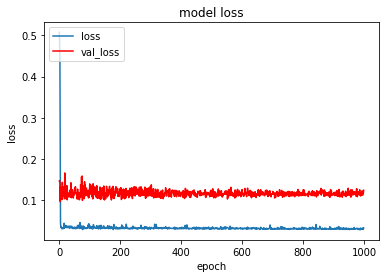

In [19]:
plt.plot(lstm_model.history['loss'])
plt.plot(lstm_model.history['val_loss'], color=  'red')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

In [20]:
pred = lstm_model.model.predict(testX_scaled, batch_size = 1)
pred
inverted = scalerX.inverse_transform(pred)
inverted

array([[5898.63  ],
       [5963.9614],
       [5581.375 ],
       [6090.9917],
       [8712.05  ],
       [9848.194 ],
       [6700.9785],
       [4836.4014],
       [3962.1428]], dtype=float32)

In [21]:
index = testX.shape[0]
result = test_ny[-index:].copy()
result = result + inverted.sum(axis = 1)
result

4/23/20    269358.629883
4/24/20    277553.961426
4/25/20    287724.375000
4/26/20    294135.991699
4/27/20    300708.049805
4/28/20    304954.194336
4/29/20    306391.978516
4/30/20    309208.401367
5/1/20     312276.142822
Name: New York, dtype: float64

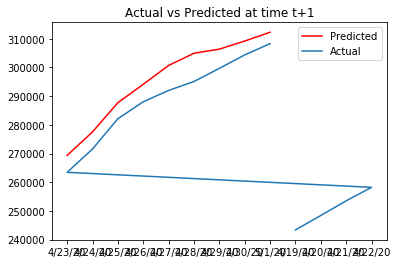

In [22]:
plt.plot(result, color='red')
plt.plot(test_ny)
plt.legend(['Predicted','Actual'])
plt.title('Actual vs Predicted at time t+1')
plt.show()

In [23]:
y_pred = np.array([237501,244349,249288,253450,258622,262926,268697,279715,292688,293945,295948])
y_true = np.array([230597,237474,243382,248416,253519,258222,263460,271590,282143,288045,291996])
root_mean_squared_log_error(y_true,y_pred)

0.024457213706969693

In [24]:
x_input = testX_scaled
index = testX.shape[0]
result = test_ny[-index:].copy()
prediction_10 = []
for i in range(1,9):
  pred = lstm_model.model.predict(x_input, batch_size = 1) 
  inverted = scalerX.inverse_transform(pred)
  result = result + inverted.sum(axis = 1)
  print(result[-1])
  prediction_10.append(result[-1])
  pred = pred.reshape(pred.shape[0],pred.shape[1] ,1)
  x_input = pred


312276.1428222656
317123.8327636719
322844.6770019531
329381.5373535156
336673.0583496094
345195.4460449219
353955.2380371094
362742.9704589844


In [25]:
test_ny

4/19/20    243382
4/20/20    248416
4/21/20    253519
4/22/20    258222
4/23/20    263460
4/24/20    271590
4/25/20    282143
4/26/20    288045
4/27/20    291996
4/28/20    295106
4/29/20    299691
4/30/20    304372
5/1/20     308314
Name: New York, dtype: int64